# Exploratory and Statistical Data Analysis for Iced company

The objective of this project is to identify patterns that determine whether a game is successful or not for sale. This will allow us to detect promising projects and plan advertising campaigns for the following year (2017).

To achieve the objective, the data received will be prepared, then analyzed in order to create a user profile for each of the relevant regions (North America, the European Union and Japan). Additionally, we will seek to answer the following hypotheses:
1. Average user ratings for Xbox One and PC platforms are the same.
2. Average user ratings for Action and Sports genres are different.

## 1. Data Preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import math

### 1.1 Reading data and searching for duplicates.

In [3]:
data = pd.read_csv('../databases/games.csv')
data.columns = data.columns.str.lower()
print(data.info())

# Búsqueda de duplicados:
print('Duplicados: ',data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
Duplicados:  0


### 1.2 Datatype conversion:

In [4]:
## CAMBIAMOS EL TIPO DE DATO DE LA COLUMNA user_score ------------------
#data['user_score'] = pd.to_numeric(data['user_score']) 
# En la coluna user_score tenemos datos no nulos, nulos y 'tbd'. Los nulos pueden provenir quizás de una mala captura de datos, o bien, aún no se han generado opiniones de los usuarios. Los 'tbd' sugieren tal vez actualizaciones en el score y este numero se este actualizando en la base de datos.

# Como los valores tbd no aportan información y no hay forma de averiguar estos valores, se forzará el cambio de 'tbd' a valores numéricos y se transformarán a NaN:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
print(data['user_score'].unique()) # There are no more 'tbd' values

[8.  nan 8.3 8.5 6.6 8.4 8.6 7.7 6.3 7.4 8.2 9.  7.9 8.1 8.7 7.1 3.4 5.3
 4.8 3.2 8.9 6.4 7.8 7.5 2.6 7.2 9.2 7.  7.3 4.3 7.6 5.7 5.  9.1 6.5 8.8
 6.9 9.4 6.8 6.1 6.7 5.4 4.  4.9 4.5 9.3 6.2 4.2 6.  3.7 4.1 5.8 5.6 5.5
 4.4 4.6 5.9 3.9 3.1 2.9 5.2 3.3 4.7 5.1 3.5 2.5 1.9 3.  2.7 2.2 2.  9.5
 2.1 3.6 2.8 1.8 3.8 0.  1.6 9.6 2.4 1.7 1.1 0.3 1.5 0.7 1.2 2.3 0.5 1.3
 0.2 0.6 1.4 0.9 1.  9.7]


### 1.3 Management of Null-values:

In [5]:
print('INITIAL PERCENTAGE OF NULL VALUES:')
print(100*data.isna().sum()/data.shape[0],'\n')

# COLUMN 'name':
# Null values are eliminated on column "name":
# Tenemos solo 2 valores ausentes:
    #display(data[data['name'].isna()])
# Eliminamos estas 2 filas del DF, dado que tiene mucha información NaN y no aporta mucho al DF:
if len(data[data['name'].isna()]) != 0:
    data = data.drop([659,14244], axis=0).reset_index(drop=True)
else:
    print("The column 'name' has no null values anymore")
#display(data.info())

# COLUMN 'year_of_release':
# Null values are filled on column 'year_of_release' with the information available on column 'name':
    #  Vemos que en algunos casos el año de lanzamiento está implicito en el nombre del juego. Para estos casos, verificamos si el nombre tiene el año de lanzamiento, si lo  tiene, copiamos el año (transformado en float) a la columna 'year_of_release:
    #   Definimos una función para extraer el año de 'name' usando expresiones regulares:
def extract_year(dataframe):
    match = re.search(r'\b(\d{4})\b', dataframe['name'])
    return float(match.group(1)) if match else dataframe['year_of_release']

years = data.apply(extract_year, axis=1) # Se extrae el año del nombre
data['year_of_release'] = data['year_of_release'].fillna(years) # Llenamos los valores ausentes hallados
#print(data.info())

# Null values are filled on column 'year_of_release' for multiplatform games:
    #df_prueba = data[data['year_of_release'].isna()]
    #display(df_prueba) # Vemos que aún hay valores ausentes, como por ejemplo: LEGO Batman: The Videogame
    # Corroboremos que no hay otras instancias del mismo juego que sí tengan año de lanzamiento. En caso de haber, debemos asignar ese año a los valores ausentes de 'year_of_release' de ese juego:
    #display(data[data['name']=='LEGO Batman: The Videogame'])
    # Con lo anterior corroboramos que puede haber juegos repetidos para multiples plataformas, pero que en algunas de ellas no está definido el año de lanzamiento. Usaremos entonces, las plataformas que sí tienen año de lanzaminto definido para asignarle el año a aquellos juegos que no lo tengan.
lista_juegos = data.groupby('name')['year_of_release'].median().round() #Usamos la mediana para obtener el valor común
data['year_of_release'] = data.set_index('name')['year_of_release'].fillna(lista_juegos).reset_index(drop=True)
#display(data.info())

print('\nFINAL PERCENTAGE OF NULL VALUES:')
print(100*data.isna().sum()/data.shape[0])

INITIAL PERCENTAGE OF NULL VALUES:
name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         54.591684
rating             40.478612
dtype: float64 


FINAL PERCENTAGE OF NULL VALUES:
name                0.000000
platform            0.000000
year_of_release     0.831688
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.313349
user_score         54.586250
rating             40.471489
dtype: float64


- After this procedure, there are still 139 games with a null-value in ***year_of_release***, however, it is no longer possible to find out the missing values with the information available in the DF
- For null values in the ***critic_score***, ***user_score*** and ***rating*** columns, there is not enough information in the DF to remove or replace these null values


### 1.4 Total sales computing

In [6]:
# Cálculo de las ventas totales:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
display(data)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16709,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16710,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


## 2. Data Analysis
#### How many games were released in different years?

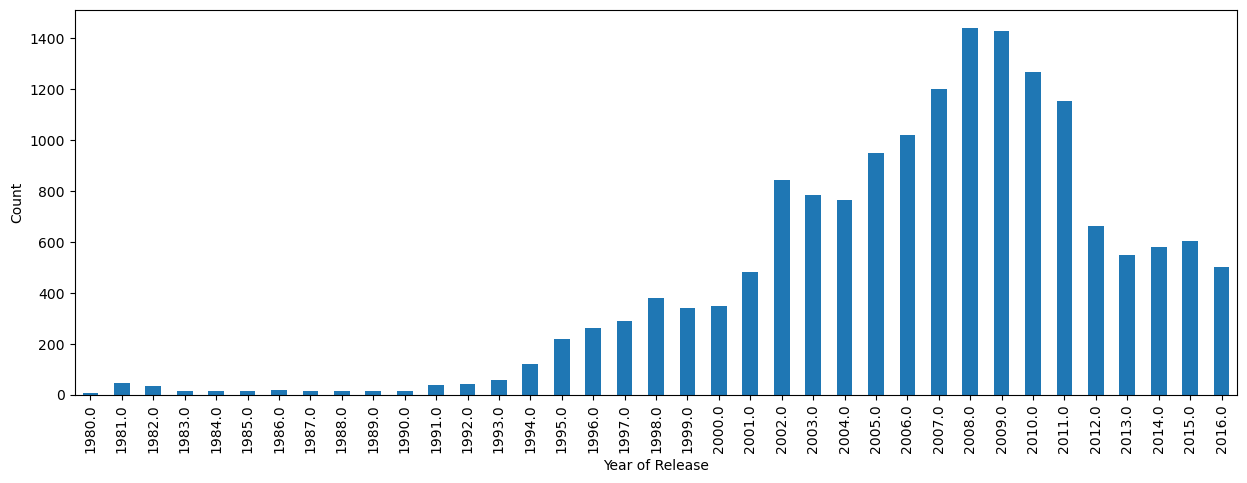

In [7]:
games_by_year = data.groupby('year_of_release')['name'].count()
#display(games_by_year)
plt.figure(1, figsize=(15,5))
games_by_year.plot(kind='bar', xlabel='Year of Release', ylabel='Count')
plt.show()

It can be seen that the difference in games released is quite different in each year, with 2008 and 2009 being the years where the most video games were launched.

#### How sales vary from one platform to another?

## 4 User Profiles

#### 4.1 Top 5 main platforms per region

In [9]:
new_data = data[data['year_of_release']>=1995]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16709,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16710,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


#### 4.2 Top 5 main genres

#### 4.3 How ESRB rating influence sales in regions